In [1]:
# !pip install opencv-python-headless==4.5.2.52
# !pip install wrapt
# !pip install mtcnn
# from mtcnn import MTCNN
# import cv2
# import matplotlib.pyplot as plt
import os
import random
import zipfile
import glob
import re
from pathlib import Path
import pandas as pd
from distutils.dir_util import copy_tree
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import subprocess
import sys
!pip install mtcnn pillow dotmap deepface
from PIL import Image

In [2]:
# if(os.path.isdir(LFW_EXTRACTION_PATH) == False):
#   shutil.rmtree('/tmp/lfw')
# if(os.path.isdir(LFW_EXTRACTION_PATH) == False):
#   shutil.rmtree('/tmp/mlfw')
# if(os.path.isdir(LFW_EXTRACTION_PATH) == False):
#   shutil.rmtree('/tmp/dataset')

In [3]:
LFW_EXTRACTION_PATH = "/tmp/lfw"
LFW_EXTRACTION_COMMAND = "tar -xvf gdrive/MyDrive/datasets/lfw.tar -C /tmp/"
MLFW_EXTRACED_PATH = "/tmp/lfw-deepfunneled"
MLFW_EXTRACTION_PATH = "/tmp/mlfw"
MLFW_EXTRACTION_FILE = "/content/gdrive/MyDrive/datasets/MLFW.zip"
MLFW_IMAGE_ORIGIN_PATH="/tmp/mlfw/aligned/*.jpg"
DRIVE_PATH='/content/gdrive'
DATASET_TRAIN_PATH='/tmp/dataset/train'
DATASET_TEST_PATH='/tmp/dataset/test'
DATASET_ROOT_PATH='/tmp/dataset'
MASKTHE_FACE_PATH="/content/gdrive/MyDrive/mfr_test_repo/MaskTheFace/"

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
def extract_lfw_mlfw():
  print("Extracing lfw and mlfw ..")
  if(os.path.isdir(LFW_EXTRACTION_PATH) == False):
    # cmd = "tar -xvf gdrive/MyDrive/datasets/lfw.tar -C /tmp/"
    returned_value = os.system(LFW_EXTRACTION_COMMAND)
  if(os.path.isdir(MLFW_EXTRACED_PATH) == True):
    os.rename(MLFW_EXTRACED_PATH, LFW_EXTRACTION_PATH)

  if(os.path.isdir(MLFW_EXTRACTION_PATH)== False):
    zip_ref = zipfile.ZipFile(MLFW_EXTRACTION_FILE, 'r')
    zip_ref.extractall(MLFW_EXTRACTION_PATH)
    zip_ref.close()

In [6]:
def pick_images_lfw(min_classes, max_classes):
  print("Picking images from lfw ..")
  lfw_images = []
  lfw_train = sorted(os.listdir(LFW_EXTRACTION_PATH))
  for directory in lfw_train:
    dir_path = LFW_EXTRACTION_PATH + "/" + directory
    no_of_files = len(os.listdir(dir_path)) 
    if(no_of_files >= min_classes and no_of_files <= max_classes):
      lfw_images.append(directory)
  return lfw_images;

In [7]:
def pick_images_mlfw(min_classes, max_classes):
  print("Picking images from mlfw ..")
  file_list = glob.glob(MLFW_IMAGE_ORIGIN_PATH)
  final_name_list = []
  for file in file_list:
      file_name = Path(file).name
      final_str = ""
      tokens = file_name.split("_")
      for token in tokens:
          if(token.isnumeric()):
              break;
          else:
              final_str += token
              final_str += "_"
      final_name_list.append(final_str)  
  df = pd.DataFrame(final_name_list)
  df.columns = ['name']
  new_df = df.groupby('name').filter(lambda x : (len(x) >= min_classes and len(x) <= max_classes))
  mlfw_images = new_df.values.tolist()
  mlfw_images = [sub[0][ : -1] for sub in mlfw_images]
  return list(set(mlfw_images))


In [8]:
def create_common_dir_list(min_classes, max_classes):
  print("create_common_dir_list ..")
  extract_lfw_mlfw();
  lfw_dir = pick_images_lfw(min_classes, max_classes);
  mlfw_dir = pick_images_mlfw(min_classes, max_classes)
  common_set = set(lfw_dir) & set(mlfw_dir)
  print("common_dir_list = " + str(len(common_set)))
  return list(common_set)

In [9]:
def pick_classes(no_of_classes, min_classes, max_classes):
  print("Picking classes ..")
  final_list = []
  filtered_list =  create_common_dir_list(min_classes, max_classes)
  # print("filtered_list_length = " + str(len(filtered_list)))
  for i in range(0, no_of_classes):
      final_list.append(random.choice(filtered_list))
  return final_list

In [10]:
def create_train_test_set_from_lfw_mlfw(number_of_classes, min_classes, max_classes):
  print("create_train_test_set_from_lfw_mlfw ..")
  final_class_list = pick_classes(number_of_classes, min_classes, max_classes)
  # print(final_class_list)
  if(os.path.isdir(DATASET_TRAIN_PATH) == True):
    shutil.rmtree(DATASET_TRAIN_PATH)
  if(os.path.isdir(DATASET_TEST_PATH) == True):
    shutil.rmtree(DATASET_TEST_PATH)
  if(os.path.isdir(DATASET_ROOT_PATH)  == False):
    os.mkdir(DATASET_ROOT_PATH)
  if(os.path.isdir(DATASET_TRAIN_PATH)== False):
    os.mkdir(DATASET_TRAIN_PATH)
  if(os.path.isdir(DATASET_TEST_PATH)== False):
    os.mkdir(DATASET_TEST_PATH)

  for dir in final_class_list:
    cmd_str = "cp -r " + LFW_EXTRACTION_PATH + "/" +dir + " " + DATASET_TRAIN_PATH
    # print(cmd_str)
    os.system(cmd_str)
  
  mlfw_jpg_list = glob.glob(MLFW_IMAGE_ORIGIN_PATH);
  # print
  # for path, subdirs, files in os.walk(MLFW_IMAGE_ORIGIN_PATH):
  #     print("path = ",path)
  #     for name in files:
  #         mlfw_jpg_list.append(os.path.join(path, name))

  # print("mlfw_jpg_list", mlfw_jpg_list)
  for dir in final_class_list:
    test_dir = DATASET_TEST_PATH + "/"+ dir
    # print(test_dir)
    if(os.path.isdir(test_dir)  == False):
      os.mkdir(DATASET_TEST_PATH + "/" +dir)
    name_list = [k for k in mlfw_jpg_list if dir in k]
    # print("name_list", name_list)
    for nme in name_list:
      copy_path = DATASET_TEST_PATH +  "/"+ dir + "/"
      # print(nme, copy_path)
      shutil.copy(nme, DATASET_TEST_PATH +  "/"+ dir + "/")

In [11]:
from mtcnn.mtcnn import MTCNN
from numpy import asarray
import cv2
 
# extract a single face from a given photograph
def process_face(filename, required_size=(256, 256)):
  # load image from file
  image = Image.open(filename)
  # convert to RGB, if needed
  # image = cv2.imread(filename)
  if(image.width != required_size[0]):
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    if(results):
      # extract the bounding box from the first face
      x1, y1, width, height = results[0]['box']
      # bug fix
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
      # extract the face
      # image = image[y1:y2, x1:x2]
      facepixels = pixels[y1:y2, x1:x2]
      # resize pixels to the model size
      image = Image.fromarray(facepixels)
      # image = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      image = image.resize(required_size)
      # cv2.resize(image, required_size)
      # face_array = asarray(image)
      # cv2.imwrite(filename, image)
      image.save(filename)

In [12]:
def get_image_list_from_folder(path):
  final_list = []
  for path, subdirs, files in os.walk(path):
    for name in files:
        final_list.append(os.path.join(path, name))
  return sorted(final_list)

def process_faces(image_list):
  for file in image_list:
    process_face(file)

In [13]:
def plot_images(w, h, fig_w, fig_h, image_list, columns, rows):
  fig = plt.figure(figsize=(fig_w, fig_h))
  for i in range(1, columns*rows +1):
      img = mpimg.imread(image_list[i])
      fig.add_subplot(rows, columns, i)
      plt.title(os.path.basename(image_list[i]))
      plt.imshow(img)
  plt.show()

In [14]:
def face_align(test_set):
  for instance in test_set:
      alignedFace = alignFace(instance)
      plt.imshow(alignedFace[:, :, ::-1])
      plt.show()
      
      img, gray_img = detectFace(alignedFace)
      plt.imshow(img[:, :, ::-1])
      plt.show()

In [15]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [16]:
!pip install watchdog

In [68]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab.patches import cv2_imshow
def augument_mask_data():
  print("Augumenting data ..")
  os.chdir(MASKTHE_FACE_PATH)
  # print("Current path=",os.getcwd())
  # os.system('pip install -r requirements.txt')
  for path in Path(DATASET_TRAIN_PATH).rglob('*.jpg'):
    # print(path)
    subprocess.run(["python", "/content/gdrive/MyDrive/mfr_test_repo/MaskTheFace/mask_the_face.py",'--path', path, '--mask_type', 'random', '--verbose', '--write_original_image'])
    files = Path(DATASET_TRAIN_PATH).rglob('*.jpg')
    recent_file =  max(files , key=os.path.getctime)
    process_train_images()
    model = keras.models.load_model('/content/gdrive/MyDrive/mfr_test_repo/strv-ml-mask2face/mask2face_siva_trained/')
    print(type(recent_file))
    image = Image.open(recent_file)
    print(image.size)
    image = tf.expand_dims(img_to_array(image), axis=0)  
    # print(image.dim)
    # img_to_array
    print(image.shape)
    generated_output = model.predict((image))
    print(generated_output[0].shape)
    cv2_imshow(generated_output[0])

In [18]:
import math 
def plot_train_list():
  print("plotting created training list...")
  train_list = get_image_list_from_folder(DATASET_TRAIN_PATH)
  # print(train_list)
  process_faces(train_list)
  train_len = int(len(train_list))
  per_row = int(math.sqrt(train_len))
  plot_images(10, 10, 50, 50, train_list, per_row, per_row)
  # print(train_list)

In [19]:
def plot_test_list():
  print("plotting created testing list...")
  test_list = get_image_list_from_folder(DATASET_TEST_PATH)
  # print(test_list)
  process_faces(test_list)
  test_len = int(len(test_list))
  per_row = int(math.sqrt(test_len))
  plot_images(10, 10, 50, 50, test_list, per_row, per_row)

In [20]:
import tensorflow as tf
from tensorflow.keras import backend, layers, metrics

# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

# from tensorflow.keras.utils import plot_model
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def get_resnet_embedding():
    base_cnn = tf.keras.applications.resnet50.ResNet50(
      weights="imagenet", input_shape= (224,224,3), include_top=False)

    flatten = layers.Flatten()(base_cnn.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    encode_model = Model(base_cnn.input, output, name="Encode_Model")

    trainable = False
    for layer in base_cnn.layers:
      if layer.name == "conv5_block1_out":
          trainable = False
      layer.trainable = trainable
    # image = tf.keras.utils.load_img(filename)
    # image = image.resize((224,224), Image.NEAREST)
    # print("size = ", image.size)
    return encode_model()

In [21]:
def get_embedding_list(path, model_name):
  print("get_embedding_list ...")
  img_list = get_image_list_from_folder(path)
  embedding_list = list()
  for file in img_list:
    embedding = []
    if(model_name == 'resnet'):
      embedding = get_resnet_embedding(file)
    else:
      embedding = DeepFace.represent(file, model_name = model_name, enforce_detection =False)
    embedding_list.append(embedding)
  final_name_list = []
  for file in img_list:
      file_name = Path(file).name
      final_str = ""
      tokens = file_name.split("_")
      for token in tokens:
          token = token.split(".",1)[0]
          if(token.isnumeric()):
              break;
          else:
              final_str += token
              final_str += "_"
      final_name_list.append(final_str) 
  final_name_list = [sub[ : -1] for sub in final_name_list]
  return embedding_list, final_name_list

In [22]:
  def process_train_images():
    for path in Path(DATASET_TRAIN_PATH).rglob('*.jpg'):
      # print(path)
      process_face(path)

In [29]:
def create_embeddings(model_name, number_of_classes, min_classes, max_classes, force_create):
  print("creating embeddings ...")
  if(os.path.isdir(DATASET_TRAIN_PATH) == False or force_create == True):
    create_train_test_set_from_lfw_mlfw(number_of_classes, min_classes, max_classes)
    augument_mask_data()
  # process_train_images()
  # plot_train_list()
  # plot_test_list()
  newTrainX, trainy = get_embedding_list(DATASET_TRAIN_PATH, model_name)
  newTrainX = asarray(newTrainX)
  newTestX, testy = get_embedding_list(DATASET_TEST_PATH, model_name)
  newTestX = asarray(newTestX)
  return newTrainX, trainy, newTestX, testy


In [24]:
def rearrange_dim(input):
  in_encoder = Normalizer(norm='l2')
  # nsamples, nx, ny = input.shape
  # input = input.reshape((nsamples,nx*ny))
  input = in_encoder.transform(input)
  return input

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def predict_accuracy(trainX, trainy, testX, testy):
  print("predicting accuracy ...")
  in_encoder = Normalizer(norm='l2')
  trainX = rearrange_dim(trainX)
  testX = rearrange_dim(testX)
  # nsamples, nx, ny = trainX.shape
  # trainX = trainX.reshape((nsamples,nx*ny))
  # trainX = in_encoder.transform(trainX)
  # nsamples, nx, ny = testX.shape
  # testX = testX.reshape((nsamples,nx*ny))
  # testX = in_encoder.transform(testX)
  # label encode targets
  out_encoder = LabelEncoder()
  out_encoder.fit(trainy)

  trainy = out_encoder.transform(trainy)
  testy = out_encoder.transform(testy)
  # trainy = rearrange_dim(trainy)
  # testy = rearrange_dim(testy)
  # fit model
  model = SVC(kernel='linear', probability=True)
  model.fit(trainX, trainy)
  # predict
  yhat_train = model.predict(trainX)
  yhat_test = model.predict(testX)
  # score
  score_train = accuracy_score(trainy, yhat_train)
  score_test = accuracy_score(testy, yhat_test)
  print("test score = >", score_test)
  # # summarize
  # #Generate the confusion matrix
  # cf_matrix = confusion_matrix(testX, yhat_test)
  # print(cf_matrix)
  # print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

  # ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  # ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  # ax.set_xlabel('\nPredicted Values')
  # ax.set_ylabel('Actual Values ');

  # ## Ticket labels - List must be in alphabetical order
  # ax.xaxis.set_ticklabels(['False','True'])
  # ax.yaxis.set_ticklabels(['False','True'])

  # ## Display the visualization of the Confusion Matrix.
  # plt.show()

In [26]:
from deepface import DeepFace
from numpy import asarray
def run_fr_test( number_of_classes, min_classes, max_classes, force_create=False):
  # models_list = ['Facenet', 'OpenFace', 'DeepFace', 'VGG-Face']
  models_list = ['Facenet']
  for model_name in models_list:
    trainX, trainy, testX, testy = create_embeddings(model_name,  number_of_classes, min_classes, max_classes, force_create)
    print("Trying with model " + model_name)
    predict_accuracy(trainX, trainy, testX, testy)
    print("----------------------------------------------------------------------------------------------------")

creating embeddings ...
create_train_test_set_from_lfw_mlfw ..
Picking classes ..
create_common_dir_list ..
Extracing lfw and mlfw ..
Picking images from lfw ..
Picking images from mlfw ..
common_dir_list = 104
Augumenting data ..
<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


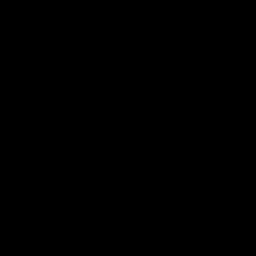

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


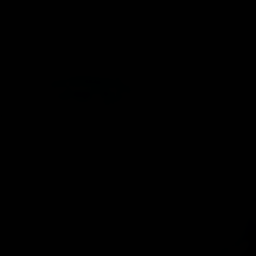

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


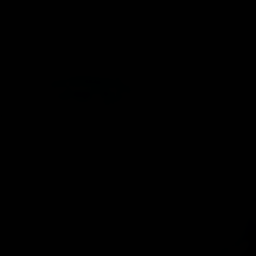

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


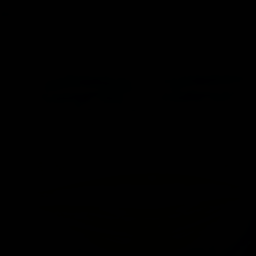

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


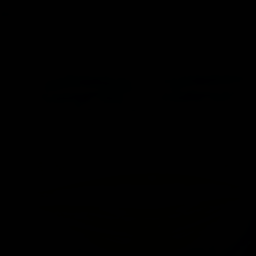

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


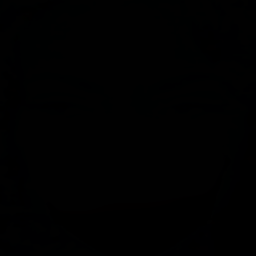

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


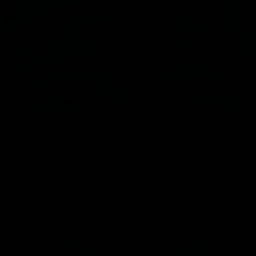

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


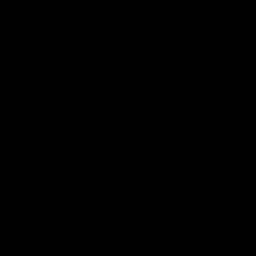

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


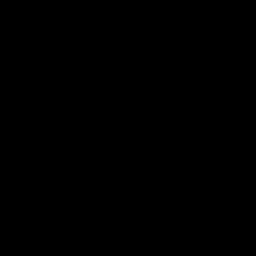

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


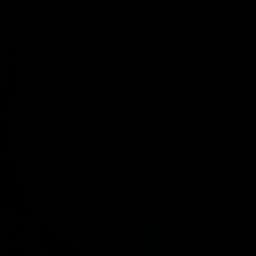

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


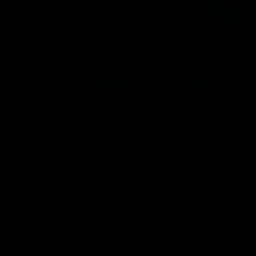

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


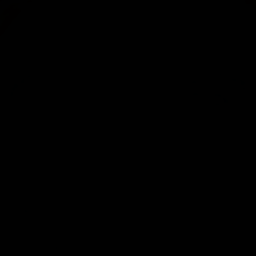

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


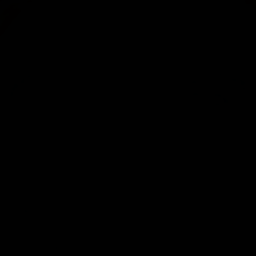

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


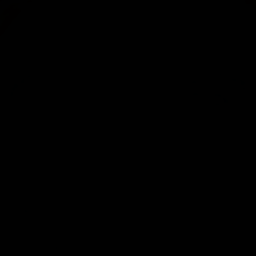

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


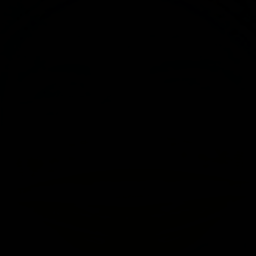

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


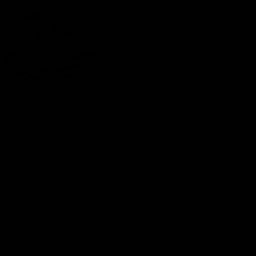

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


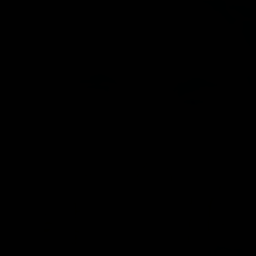

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


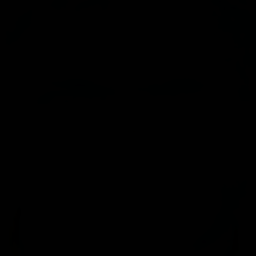

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


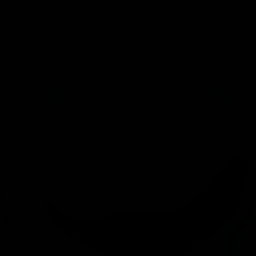

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


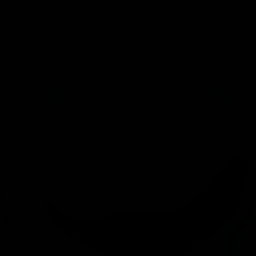

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


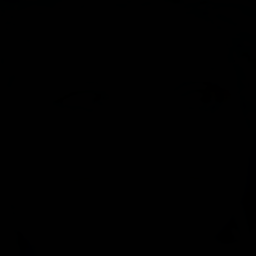

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


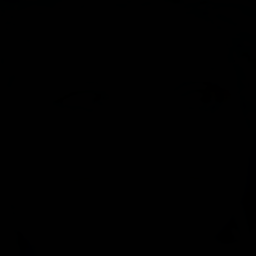

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


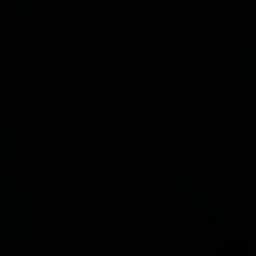

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


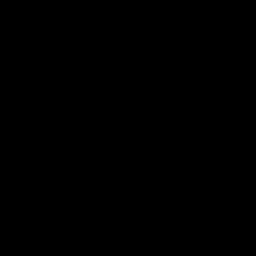

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


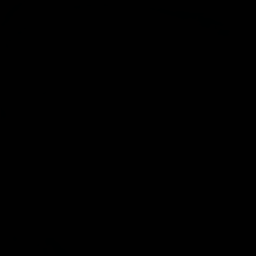

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


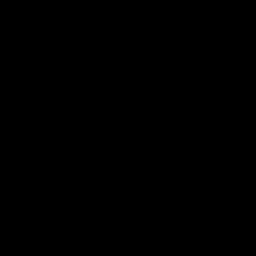

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


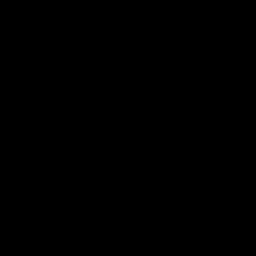

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


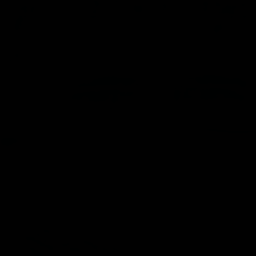

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


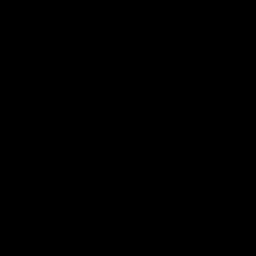

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


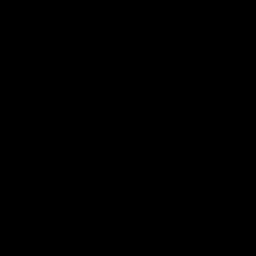

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


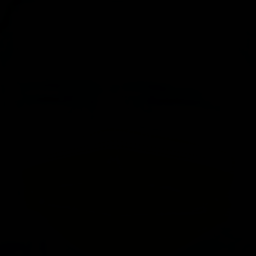

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


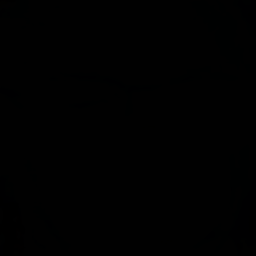

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


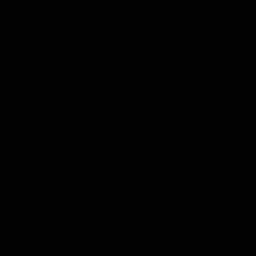

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


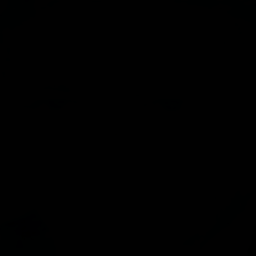

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


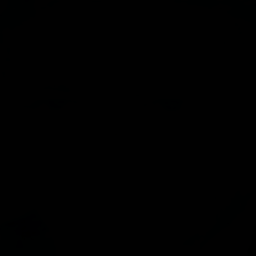

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


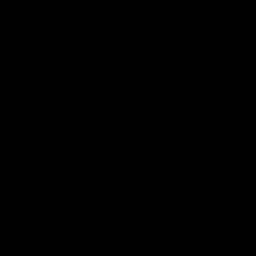

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


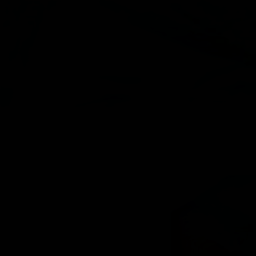

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


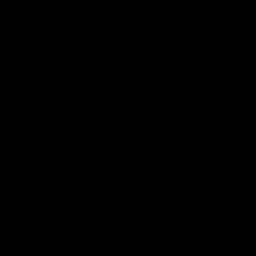

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


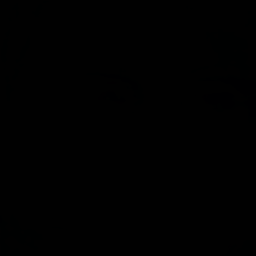

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


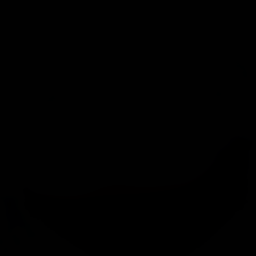

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


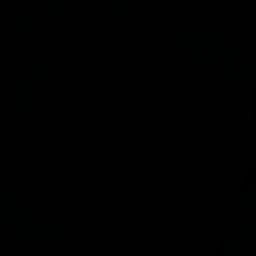

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


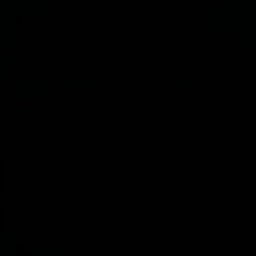

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


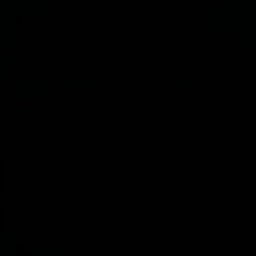

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


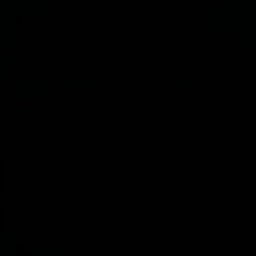

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


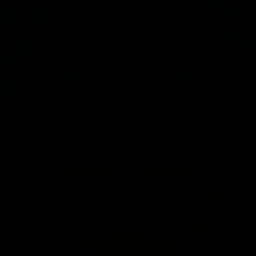

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


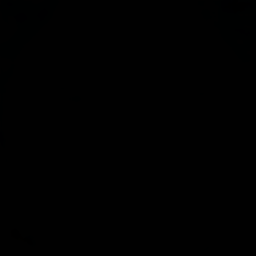

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


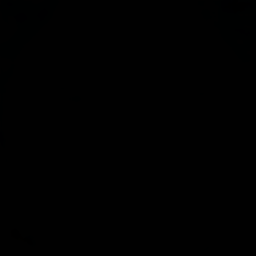

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


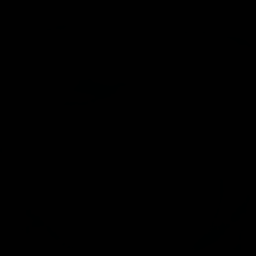

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


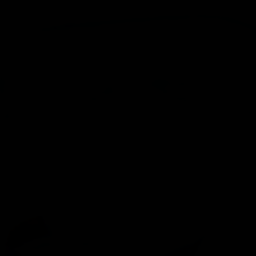

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


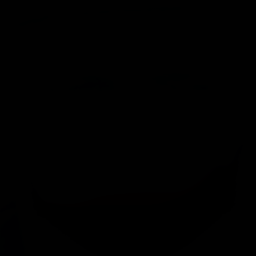

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


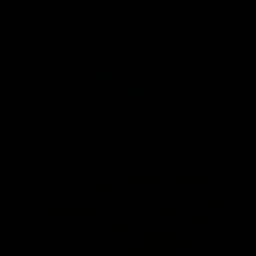

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


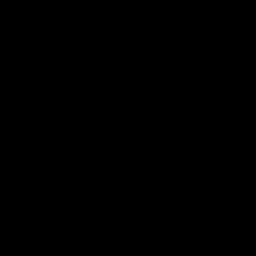

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


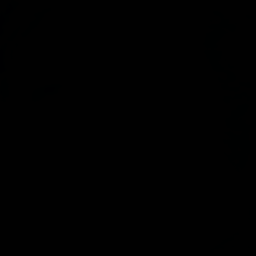

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


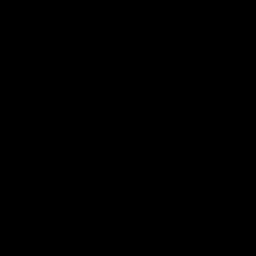

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


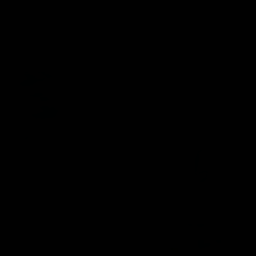

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


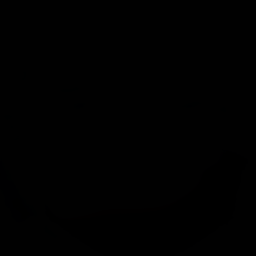

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


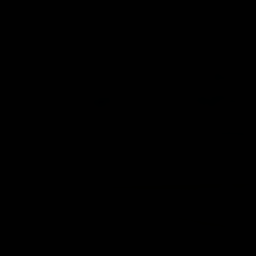

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


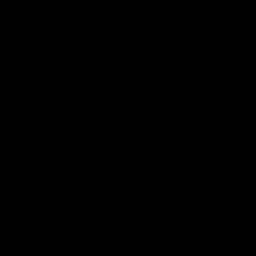

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


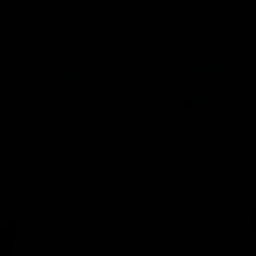

<class 'pathlib.PosixPath'>
(256, 256)
(1, 256, 256, 3)
(256, 256, 3)


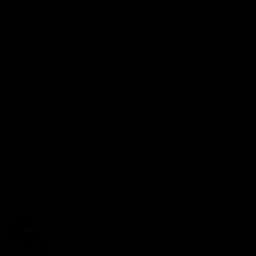

get_embedding_list ...
facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:18<00:00, 4.87MB/s]


get_embedding_list ...
Trying with model Facenet
predicting accuracy ...
test score = > 0.7794117647058824
----------------------------------------------------------------------------------------------------


In [69]:
run_fr_test(10, 5, 10, force_create=True)

In [ ]:
run_fr_test(10, 1, 2, force_create=True)

In [ ]:
run_fr_test(20, 3, 5, force_create=True)

In [ ]:
run_fr_test(20, 1, 1, force_create=True)

In [ ]:
run_fr_test(30, 3, 5, force_create=True)

In [ ]:
run_fr_test(40, 3, 5, force_create=True)